In [110]:
import os
from PIL import Image
import numpy as np
import re

data_directory = './dataset/jacobus.v5i.png-mask-semantic'
# List all files in the data directory recursively

file_list = []
for root, dirs, files in os.walk(data_directory):
    for file in files:
        if file.endswith("_mask.png"):
            file_list.append(os.path.join(root, file))

print(f'Found {len(file_list)} files')


Found 177 files


Example file: ./dataset/jacobus.v5i.png-mask-semantic/valid/Hawaiian-Shirt-Man-01-Jab_mp4-4_jpg.rf.0f33a523321a01b3157ebd54ad21afa9_mask.png
Image shape: (512, 512)
Image dtype: uint8


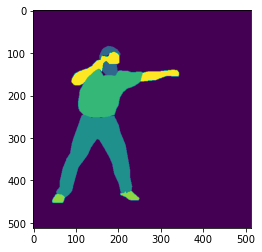

Unique values: [0 2 3 4 5 6]


In [111]:
test_file = file_list[0]

print(f'Example file: {test_file}')

# Open the file and show it
image = Image.open(test_file)
image_array = np.array(image)
print(f'Image shape: {image_array.shape}')
print(f'Image dtype: {image_array.dtype}')

# Show the image
import matplotlib.pyplot as plt

plt.imshow(image_array)
plt.show()

# Show the unique values in the image
print(f'Unique values: {np.unique(image_array)}')



In [112]:

# Background: '#000000'
# Gun: '#292929'
# Hair: '#453211'
# Pants: #926106
# Shirt: #0084b0
# Shoes: #c9c9c9
# Skin: #ffe3b9

colors_rgb = {
    0: (0, 0, 0), # Background
    1: (41, 41, 41), # Gun
    2: (69, 50, 17), # Hair
    3: (146, 97, 6), # Pants
    4: (0, 132, 176), # Shirt
    5: (201, 201, 201), # Shoes
    6: (255, 227, 185), # Skin
}

# The bias that we use to prefer some colors over others
colors_bias = {
    0: 0.25, # Background
    1: 4, # Gun
    2: 2, # Hair
    3: 1, # Pants
    4: 1, # Shirt
    5: 2, # Shoes
    6: 1, # Skin
}


def resize_image_with_bias(input_image, dest_size=(64,64), use_bias=True):
    orig_size = input_image.size
    image_array = np.array(input_image)

    # Shrink the image to 64x64, but each pixel uses the majority color in the 8x8 block

    # Allocate a new RGB image of the destination size
    image_sm = Image.new('RGB', dest_size)
    image_sm_array = np.array(image_sm)

    block_size_x = int(orig_size[0] / dest_size[0])
    block_size_y = int(orig_size[1] / dest_size[1])

    # Iterate over the destination image
    for i in range(0, dest_size[0]):
        for j in range(0, dest_size[1]):
            # Get the 8x8 block from the source image
            block = image_array[i * block_size_x:(i + 1) * block_size_x, j * block_size_y:(j + 1) * block_size_y]
            # Get the unique values in the block
            unique, counts = np.unique(block, return_counts=True)
            if use_bias:
                # Modify the counts by the bias for each color
                for k in range(0, len(unique)):
                    counts[k] = int(counts[k] * colors_bias[unique[k]])
            
            # Get the index of the most common value
            most_common_index = np.argmax(counts)
            # Set the pixel in the destination image to the most common value
            color_rgb = colors_rgb[unique[most_common_index]]

            image_sm_array[i][j] = color_rgb

    # Convert the array back to an image
    image_sm = Image.fromarray(image_sm_array)

    return image_sm


def resize_image_nearest(input_image, dest_size=(64,64)):
    image_sm = input_image.resize(dest_size, Image.NEAREST)
    image_sm_array = np.array(image_sm)

    # Color the image according to the colors_rgb dictionary
    image_sm_rgb = image_sm.convert('RGB')
    image_sm_rgb_array = np.array(image_sm_rgb)

    for i in range(0, 64):
        for j in range(0, 64):
            #print(f'[{i}][{j}] = {image_sm_array[i][j]}')
            image_sm_rgb_array[i][j] = colors_rgb[image_sm_array[i][j]]

    image_sm_rgb = Image.fromarray(image_sm_rgb_array)  
    
    return image_sm_rgb

Example file: ./dataset/jacobus.v5i.png-mask-semantic/valid/Hawaiian-Shirt-Man-01-Jab_mp4-4_jpg.rf.0f33a523321a01b3157ebd54ad21afa9_mask.png
Original image:


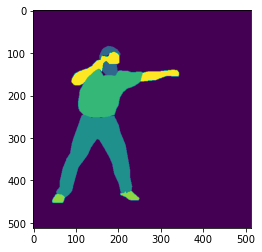

Nearest neighbor


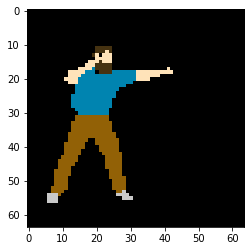

No bias


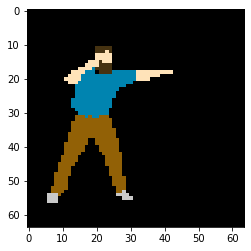

With bias


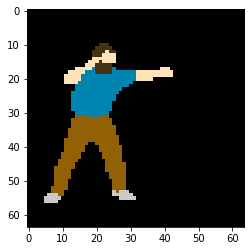

In [113]:
test_file = file_list[0]

print(f'Example file: {test_file}')

# Open the file and show it
image = Image.open(test_file)
image_array = np.array(image)

# Shrink the image with each method
image_sm_bias = resize_image_with_bias(image)
image_sm_nearest = resize_image_nearest(image)
image_sm_nobias = resize_image_with_bias(image, use_bias=False)

print('Original image:')
plt.imshow(image)
plt.show()

# Show the images
print('Nearest neighbor')
plt.imshow(image_sm_nearest)
plt.show()

print('No bias')
plt.imshow(image_sm_nobias)
plt.show()

print('With bias')
plt.imshow(image_sm_bias)
plt.show()

In [114]:
os.makedirs('./dataset/nearest/', exist_ok=True)
os.makedirs('./dataset/nobias/', exist_ok=True)
os.makedirs('./dataset/bias/', exist_ok=True)

# Compile regex for finding numbers in filenames
import re

single_digit_regex = re.compile(r'-(\d)_')

for filename in file_list:
    image = Image.open(filename)
    # Get the filename without the directory
    simple_filename = os.path.basename(filename)
    # Remove the file extension
    simple_filename = os.path.splitext(simple_filename)[0]

    # Look for anything with a number like '-%d_' and convert it to have a leading zero like '-%02d_'
    simple_filename = single_digit_regex.sub(r'-0\1_', simple_filename)

    for size in [24, 32, 48, 64, 96]:
        os.makedirs(f'./dataset/bias_{size}/', exist_ok=True)
        image_bias = resize_image_with_bias(image, dest_size=(size, size))
        image_bias.save(f'./dataset/bias_{size}/' + simple_filename + '.png')

    #image_nobias = resize_image_with_bias(image, use_bias=False)
    #image_nobias.save('./dataset/nobias/' + simple_filename + '.png')

    #image_nearest = resize_image_nearest(image)
    #image_nearest.save('./dataset/nearest/' + simple_filename + '.png')


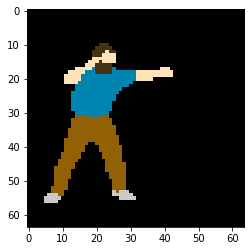

In [115]:
dest_size = 64

# Shrink the image to 64x64, but each pixel uses the majority color in the 8x8 block

# Allocate a new RGB image of the destination size
image_sm = Image.new('RGB', (dest_size, dest_size))
image_sm_array = np.array(image_sm)

# Iterate over the destination image
for i in range(0, dest_size):
    for j in range(0, dest_size):
        # Get the 8x8 block from the source image
        block = image_array[i*8:i*8+8, j*8:j*8+8]
        # Get the unique values in the block
        unique, counts = np.unique(block, return_counts=True)
        # Modify the counts by the bias for each color
        for k in range(0, len(unique)):
            counts[k] = int(counts[k] * colors_bias[unique[k]])
        # Set the count of the background to 0
        #if unique[0] == 0:
        #    counts[0] = counts[0] / 4
        
        # Get the index of the most common value
        most_common_index = np.argmax(counts)
        # Set the pixel in the destination image to the most common value
        color_rgb = colors_rgb[unique[most_common_index]]
        #print(color_rgb)
        image_sm_array[i][j] = color_rgb

# Convert the array back to an image
image_sm = Image.fromarray(image_sm_array)
plt.imshow(image_sm)
plt.show()

